In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [2]:
# dirs = glob.glob('../data/snakes/*')
data_dir = '../data/snakes/'

In [3]:
# Find the max image size
def find_max_image_size(data_dir):
    max_width, max_height = 0, 0
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    width, height = img.size
                    max_width = max(max_width, width)
                    max_height = max(max_height, height)
    return max_width, max_height

In [55]:
def pad_image_to_max(image):
    delta_width = self.max_width - image.size[0]
    delta_height = self.max_height - image.size[1]
    padding = (delta_width // 2, delta_height // 2, delta_width - (delta_width // 2), delta_height - (delta_height // 2))
    return ImageOps.expand(image, padding, fill=0)  # fill=0 for black padding


In [79]:

def load_data(data_dir, batch_size=32, customized_size=False, target_size=(224, 224)):
    '''
        If customized_size is False, the max image size will be used.
    '''
    if customized_size:
        transform = transforms.Compose([
            # transforms.Resize(target_size),
            transforms.Lambda(lambda x: transforms.functional.pad(x, (
                (target_size[0] - x.size[0]) // 2, 
                (target_size[1] - x.size[1]) // 2, 
                (target_size[0] - x.size[0]) - ((target_size[0] - x.size[0]) // 2), 
                (target_size[1] - x.size[1]) - ((target_size[1] - x.size[1]) // 2)
            ), fill=0)),
            transforms.ToTensor(),
            # Use ImageNet mean and std temporarily, we can also calculate the mean and std of our dataset
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        ])
    else:
        max_width, max_height = find_max_image_size(data_dir)
        max_size = (max_width, max_height)
        print('Max image size: {} x {}'.format(max_size[0], max_size[1]))
        transform = transforms.Compose([
            # transforms.Resize(max_size),
            # transforms.Lambda(lambda x: transforms.functional.pad(x, (0, 0, max_size[0] - x.size[0], max_size[1] - x.size[1]), fill=0)),
            transforms.Lambda(lambda x: transforms.functional.pad(x, (
                (max_size[0] - x.size[0]) // 2, 
                (max_size[1] - x.size[1]) // 2, 
                (max_size[0] - x.size[0]) - ((max_size[0] - x.size[0]) // 2), 
                (max_size[1] - x.size[1]) - ((max_size[1] - x.size[1]) // 2)
            ), fill=0)),
            transforms.ToTensor(),
            # Use ImageNet mean and std temporarily, we can also calculate the mean and std of our dataset
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Splitting the dataset into training, validation, and testing
    num_data = len(dataset)
    print('Number of data: {}'.format(num_data))
    indices = list(range(num_data))
    split_train = int(0.6 * num_data)
    split_val = int(0.8 * num_data)

    # Shuffling indices
    np.random.shuffle(indices)

    # Creating data samplers
    train_idx, val_idx, test_idx = indices[:split_train], indices[split_train:split_val], indices[split_val:]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Creating data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    loaders = {
        'train': train_loader,
        'valid': val_loader,
        'test': test_loader
    }

    return loaders

In [86]:
## Usage example

resize_option = False

# Used if resize_option is True
target_size = (224, 224)  

loaders = load_data(data_dir, customized_size=resize_option, target_size=target_size)

Max image size: 500 x 500
Number of data: 7753


In [87]:
print('Number of training samples: {}'.format(len(loaders['train'].sampler)))
print('Number of validation samples: {}'.format(len(loaders['valid'].sampler)))
print('Number of test samples: {}'.format(len(loaders['test'].sampler)))

Number of training samples: 4651
Number of validation samples: 1551
Number of test samples: 1551


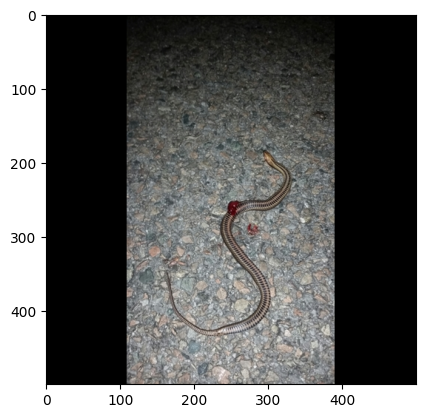

In [88]:
# show a random sample
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)

images, labels = next(iter(loaders['train']))
imshow(images[0])